# 클래스 선언

In [81]:
# backup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import deque
font_path = "C:\Windows\Fonts\LG_Smart_UI-Light.ttf"

from matplotlib import font_manager, rc

font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

# ## input에 대한 실린더 고장 클래스
# ## input_data(csv) 가 모여있는 디렉토리 입력.


## 실린더 정보 저장용
class CYLINDER():
    def __init__(self, is_abnormal = None, value_data = None, max_limit = None, min_limit = None, count = None):
        self.stat = is_abnormal     # 이상유무 1 = 이상, 0 = 정상 , [1, 0, 1, 0, 1] --> 0, 2, 4 번째 실린더 이상
        self.value = value_data     # 각 실린더마다 데이터
        self.max_limit = max_limit  # 각 실린더마다 상한선 변동값
        self.min_limit = min_limit  # 각 실린더마다 하한성 변동값
        self.count = count          # 넘어간 횟수

    # 요약정보 가져오기 위해
    def get(self, index):
        return [self.stat[index], self.value, self.max_limit, self.min_limit, self.count]

class CYL_DETECTOR():


    ## 초기세팅, 데이터 입력 부분
    def __init__(self, file_path):

        self.csv_path = file_path



    ## 동작시키는 함수 ##
    def run(self):

        print(f' 실린더 파일 읽는 중 ... ' , end='\r', flush=True)
        self.df = self.data_preprocess()

        print(f' 실린더 파일 읽는 중 ... 완료  ', end = "\n ", flush=True)
        self.cylinder_info_std = self.cylinder_analysis_std(self.df)
        # self.cylinder_info_crest = self.cylinder_analysis_crest(self.df)
        self.result = []

        ####

        # std와 crest 겹치는 인덱스 찾는 부분

        ####


    # 전처리 필요하면 여기 ~~~~~~~~~ 분석용 함수에 맞는 input 데이터를 제공하는 함수
    def data_preprocess(self):
        original = pd.read_csv(self.csv_path, encoding='CP949') # 시간 포함
        copy_df = pd.DataFrame(np.copy(original),columns = original.columns)    # 시간 필터링
        copy_df = copy_df.iloc[:, 1:]
        self.df_columns = copy_df.columns



        del(original)
        return copy_df


    ############################################# 한계선 ############################################
    # 상 - 하한선 결정하는 함수
    def determine_limit(self, data, sigma, weight):
        std, mean = np.std(data), np.mean(data)




        if std * sigma >= 0.05:
            upper_line = (mean + std * sigma) * (1 + weight)
            lower_line = (mean - std * sigma) * (1 - weight)
        else:
            upper_line = (mean + 0.05) * (1 + weight)
            lower_line = (mean - 0.05) * (1 - weight)

        if lower_line < 0 : lower_line = 0

        return upper_line, lower_line, std, mean
    #################################################################################################

    ############################################# 지수 ############################################

    def get_crest_factor(self, data):

        return (np.max(data) - np.min(data)) / np.sqrt(np.sum(np.power(data,2))/ len(data)) ### { 차이 / 제곱근 }
    ############################################# #### ############################################


    # input 실린더 데이터 --> 이상 실린더 리턴 (편차사용)
    def cylinder_analysis_std(self, cyl_dataframe):

        ######## 리턴용 변수 생성 ########
        type, value, max, min, cnt = [], [], [], [], []
        self.sigma, self.weight, self.limit = 3, 0.01, 100
        ##############################

        # 1. Input 데이터를 입력받는다.
        cyl_size = len(cyl_dataframe.columns)
        data_size = len(cyl_dataframe)


        ## 탐색 (전체 실린더)
        for cyl_i in range(cyl_size):
            ###### 전체 변수 & 초기화 ####
            is_abnormal, count, repeat_counter = 0, 0, 0
            upper_limit, lower_limit = [], []
            upper_line, lower_line = 0, 0
            std, mean = 0, 0
            is_collected = False


            data_box = deque()
            cylinder_data = cyl_dataframe.iloc[:, cyl_i]
            ############################

            ## 탐색 (개별 실린더)
            for idx, data in enumerate(cylinder_data):

                # 데이터 수집안됐으면 추가하고 다음으로
                if not is_collected:
                    if len(data_box) < int(data_size/ 10):
                        data_box.append(data)
                        upper_limit.append(None)
                        lower_limit.append(None)

                        continue

                    # 수집했으면 std, mean 라인 스타트
                    if len(data_box) == int(data_size/ 10):

                        upper_line, lower_line, std, mean = self.determine_limit(data_box, self.sigma, self.weight)


                        is_collected = True


                ####################### 이어서 할거 if  다음 어떻게 넘어갈지 막힘 아마도 std, mean 구해서 상하한선 구하는것부터 시작할것~~



                ## std, mean 계산하기까지 데이터 모음
                if idx % int(data_size/10) == 0:
                    tmp_data = cylinder_data[idx - int(data_size/100): idx]

                    tmp_up,tmp_dn = upper_line, lower_line
                    upper_line, lower_line, std, mean = self.determine_limit(tmp_data, self.sigma, self.weight)


                    # weight *= 0.9
                    # if std > mean * 0.01:
                    #     upper_line, lower_line = tmp_up, tmp_dn
                    #     continue


                 # if data != 0 and (data > upper_line or data < lower_line):
                #
                #
                if (data > upper_line or data < lower_line):
                    count += 1
                #
                #     # test
                    # 한계선 업데이트
                    tmp_data = cylinder_data[idx - int(data_size/100): idx]

                    tmp_up,tmp_dn = upper_line, lower_line
                    upper_line, lower_line, std, mean = self.determine_limit(tmp_data, self.sigma, self.weight)
                    if std > mean * 0.1:
                        upper_line, lower_line = tmp_up, tmp_dn


                upper_limit.append(upper_line)
                lower_limit.append(lower_line)


            if count > 200:
                is_abnormal = 1


            # print(f' 실린더 분석 중 : {cyl_i + 1}/{cyl_size} 완료',end ="\r", flush =True)
            print(f' 실린더 분석 중 : {int(( (cyl_i+1) /cyl_size)*100)}% ( {cyl_i +1} / {cyl_size} )' , end='\r', flush=True)

            if is_abnormal:
                type.append(is_abnormal)
                value.append(cylinder_data)
                max.append(upper_limit)
                min.append(lower_limit)
                cnt.append(count)

            else:
                type.append(is_abnormal)
                value.append(cylinder_data)
                max.append(upper_limit)
                min.append(lower_limit)
                cnt.append(count)

        # cylinder 정보 저장
        cylinder = CYLINDER(is_abnormal = type, value_data = value, max_limit = max, min_limit = min, count = count)
        print(f' 실린더 분석 완료 : {int(( (cyl_i+1) /cyl_size)*100)}% ( {cyl_i +1} / {cyl_size} )' , end='\r', flush=True)

        # 반환

        return cylinder

    ##############  알고리즘 - 2
    # input 실린더 데이터 --> 이상 실린더 리턴 (crest factor사용 )
    def cylinder_analysis_crest(self, cyl_dataframe):

        ######## 리턴용 변수 생성 ########
        type, value, max, min, cnt = [], [], [], [], []
        self.crest_factor_list = []
        ##############################

        # 1. Input 데이터를 입력받는다.
        cyl_size = len(cyl_dataframe.columns)
        data_size = len(cyl_dataframe)


        ## 탐색 (전체 실린더)
        for cyl_i in range(cyl_size):
            ###### 전체 변수 & 초기화 ####
            X, is_abnormal = [], 0

            crest_factor = 0
            is_collected = False


            data_box = deque()
            cylinder_data = cyl_dataframe.iloc[:, cyl_i]
            ############################

            ## 탐색 (개별 실린더)

            for idx, data in enumerate(cylinder_data):

                # 취합되지 않았다면,



                if not is_collected:
                    if len(data_box) < 60:

                        # 데이터박스에 취합
                        data_box.append(data)

                        # 다음 데이터로
                        continue

                    # 취합됐으면
                    else:
                        # Crest Factor 계산
                        crest_factor = self.get_crest_factor(data_box)

                        # 취합 됐다고 스위치 온
                        is_collected = True



                if idx % 100 == 0:
                    crest_factor = self.get_crest_factor(cylinder_data[idx-59:idx])


                if 1 < crest_factor < 3:
                    X.append(1)

                else :
                    X.append(0)



                if len(X) == 12:

                    if sum(X) >= 3:

                        is_abnormal = 1

                else :
                    continue

            type.append(is_abnormal)
            value.append(cylinder_data)



            print(f' 실린더 분석 중 : {int(( (cyl_i+1) /cyl_size)*100)}% ( {cyl_i +1} / {cyl_size} )' , end='\r', flush=True)

    # cylinder 정보 저장
        cylinder = CYLINDER(is_abnormal = type, value_data = value)
        print(f' 실린더 분석 완료 : {int(( (cyl_i+1) /cyl_size)*100)}% ( {cyl_i +1} / {cyl_size} )' , end='\r', flush=True)

        # 반환
        return cylinder


    # Test 출력용.
    def print(self):
        pass





## cylinder 끼리 비교 코드

1
3
5


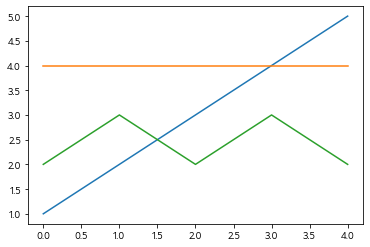

In [73]:
# a = [1,0,1,0,1]
# b = [1,1,1,1,1]
# cylinder = CYLINDER(is_abnormal=a, value_data=[1,2,3,4,5], max_limit=[4,4,4,4,4], min_limit = [2,3,2,3,2], count= 2)
# cylinder2 = CYLINDER(is_abnormal=b)
#
# list = cylinder.stat
# list2 = cylinder2.stat
# for i, d in enumerate(cylinder.stat):
#     if d in cylinder2.stat:
#         print(i+1)
#
# type, value, max, min, count = cylinder.get(1)
#
# plt.plot(value)
# plt.plot(max)
# plt.plot(min)


# 최종 클래스 동작

In [86]:
os.getcwd()

detector = CYL_DETECTOR('data/PKG4/2110/20211010.csv')

detector.run()


 실린더 파일 읽는 중 ... 완료  


### 테스트용 코드

85
89
183
219
220
223
224
249
270
278
10


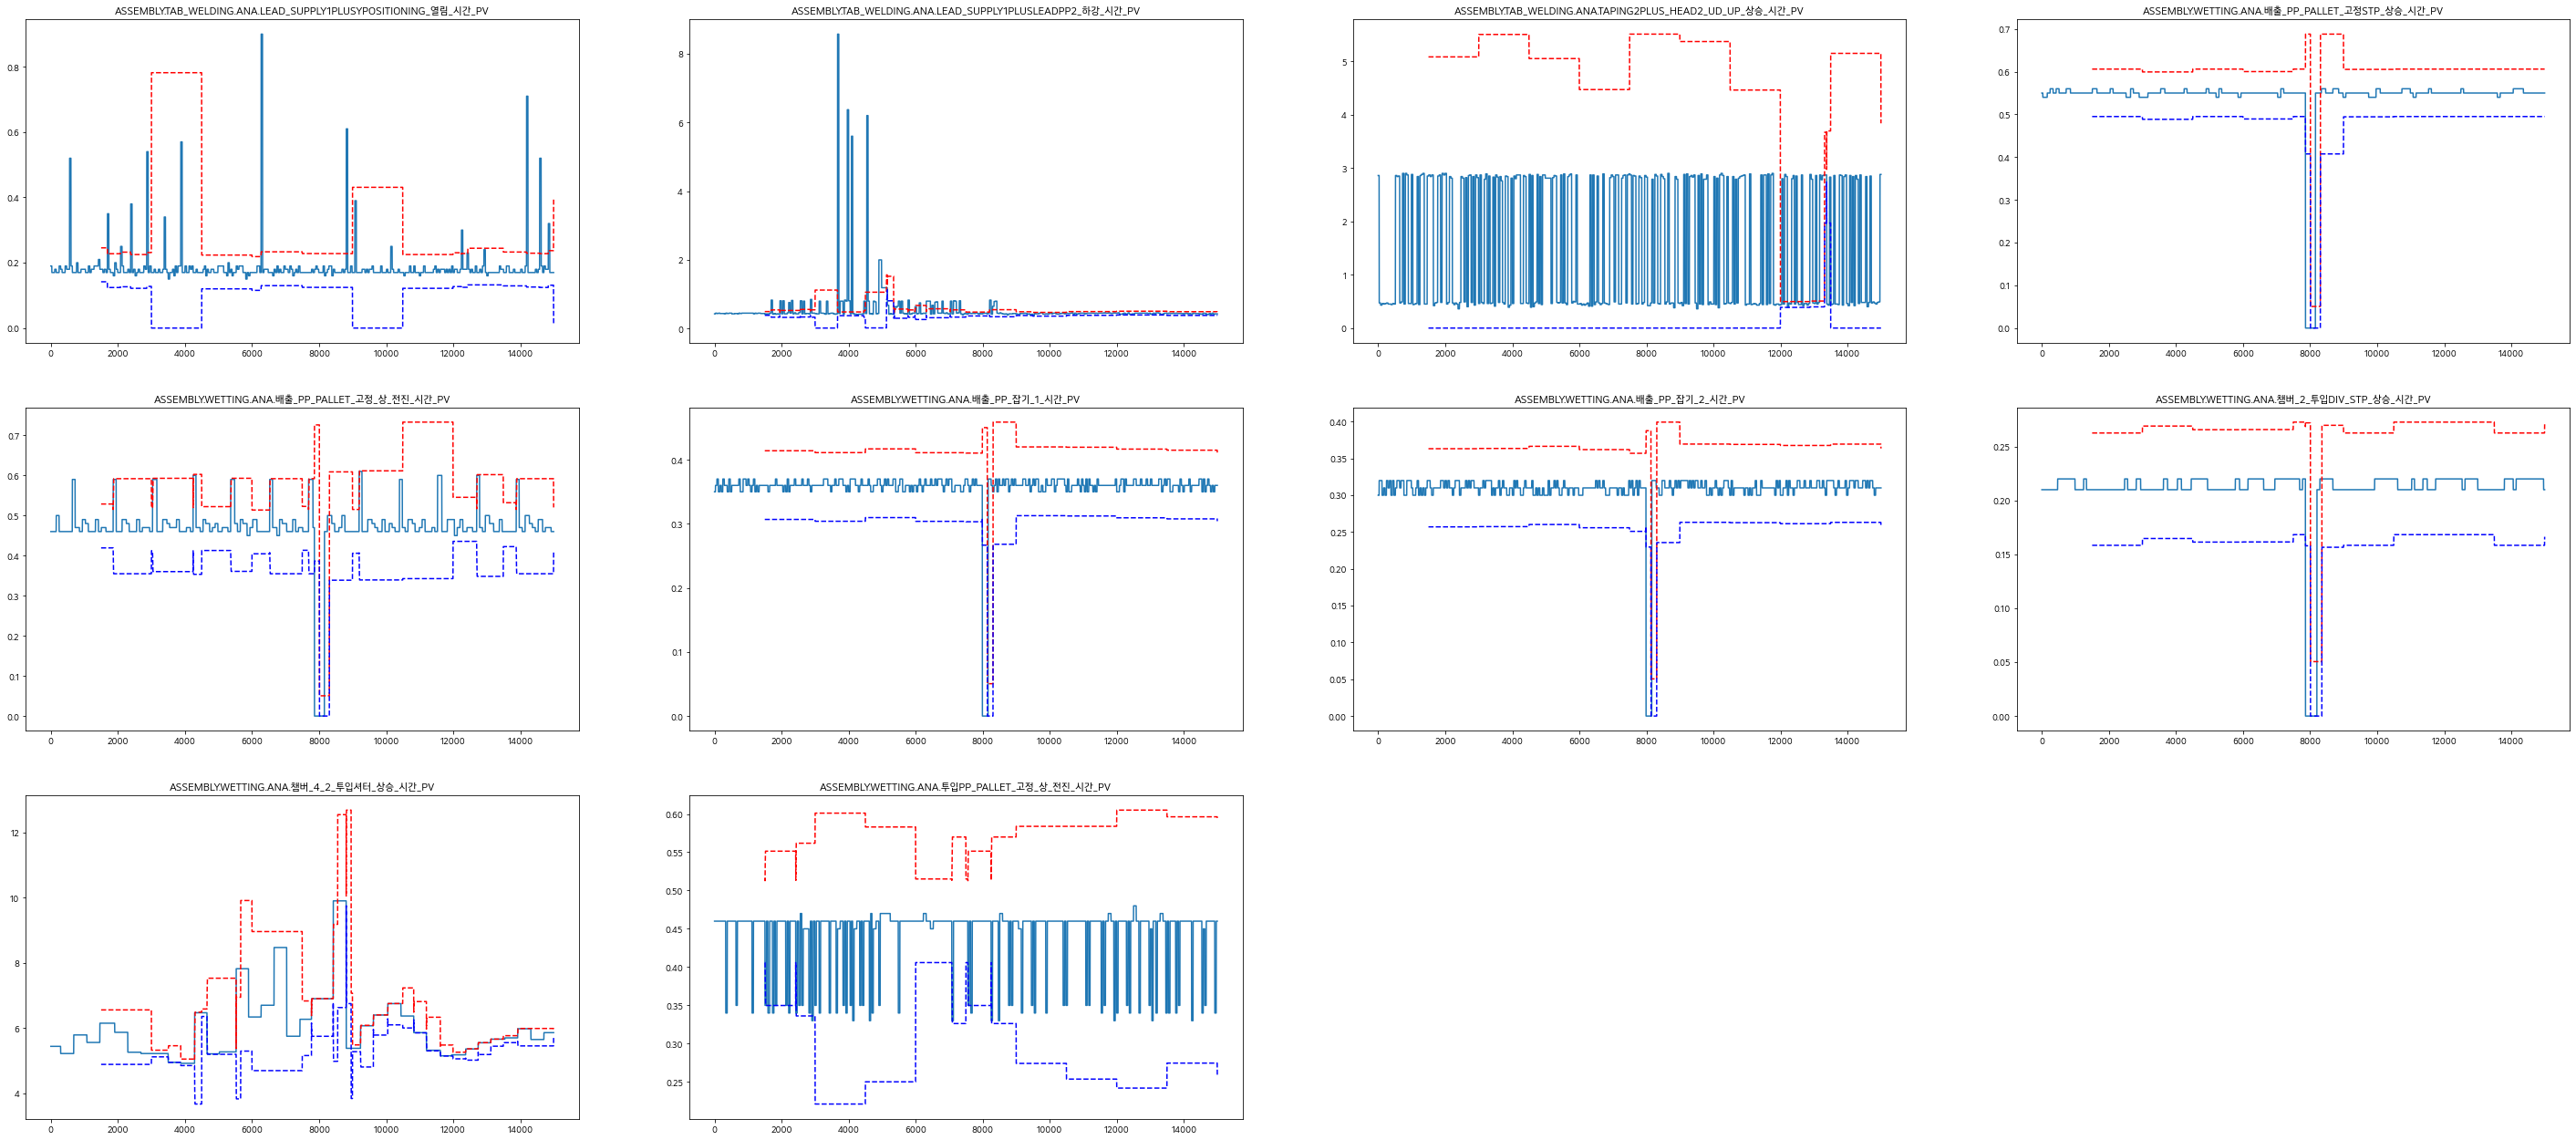

In [87]:
# detector.cylinder_info_std.value[0]


b=0
c=0
for i in detector.cylinder_info_std.stat:
    c+=1
    if i == 1 :
        b+=1
        print(c)
print(b)

plt.figure(figsize=(50,30))
b=0
c=0

for i in range(331):

    if  detector.cylinder_info_std.stat[i]:
        b+=1
        plt.subplot(4,4,b)

        plt.title(f'{detector.df_columns[c]}')
        # plt.title(detector.df_columns[b])
        plt.plot(detector.cylinder_info_std.value[i])
        plt.plot(detector.cylinder_info_std.max_limit[i], 'r--')
        plt.plot(detector.cylinder_info_std.min_limit[i], 'b--')
    c+=1

0


backup

In [ ]:
# backup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import deque
font_path = "C:\Windows\Fonts\LG_Smart_UI-Light.ttf"

from matplotlib import font_manager, rc

font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

# ## input에 대한 실린더 고장 클래스
# ## input_data(csv) 가 모여있는 디렉토리 입력.


## 실린더 정보 저장용
class CYLINDER():
    def __init__(self, is_abnormal = None, value_data = None, max_limit = None, min_limit = None, count = None):
        self.stat = is_abnormal     # 이상유무 1 = 이상, 0 = 정상 , [1, 0, 1, 0, 1] --> 0, 2, 4 번째 실린더 이상
        self.value = value_data     # 각 실린더마다 데이터
        self.max_limit = max_limit  # 각 실린더마다 상한선 변동값
        self.min_limit = min_limit  # 각 실린더마다 하한성 변동값
        self.count = count          # 넘어간 횟수

    # 요약정보 가져오기 위해
    def get(self, index):
        return [self.stat[index], self.value, self.max_limit, self.min_limit, self.count]

class CYL_DETECTOR():


    ## 초기세팅, 데이터 입력 부분
    def __init__(self, file_path):

        self.csv_path = file_path



    ## 동작시키는 함수 ##
    def run(self):

        print(f' 실린더 파일 읽는 중 ... ' , end='\r', flush=True)
        self.df = self.data_preprocess()

        print(f' 실린더 파일 읽는 중 ... 완료  ', end = "\n ", flush=True)
        self.cylinder_info_std = self.cylinder_analysis_std(self.df)
        # self.cylinder_info_crest = self.cylinder_analysis_crest(self.df)
        self.result = []

        ####

        # std와 crest 겹치는 인덱스 찾는 부분

        ####


    # 전처리 필요하면 여기 ~~~~~~~~~ 분석용 함수에 맞는 input 데이터를 제공하는 함수
    def data_preprocess(self):
        original = pd.read_csv(self.csv_path, encoding='CP949') # 시간 포함
        copy_df = pd.DataFrame(np.copy(original),columns = original.columns)    # 시간 필터링
        copy_df = copy_df.iloc[:, 1:]
        self.df_columns = copy_df.columns



        del(original)
        return copy_df


    ############################################# 한계선 ############################################
    # 상 - 하한선 결정하는 함수
    def determine_limit(self, data, sigma, weight):
        std, mean = np.std(data), np.mean(data)




        if std * sigma >= 0.05:
            upper_line = (mean + std * sigma) * (1 + weight)
            lower_line = (mean - std * sigma) * (1 - weight)
        else:
            upper_line = (mean + 0.05) * (1 + weight)
            lower_line = (mean - 0.05) * (1 - weight)

        if lower_line < 0 : lower_line = 0

        return upper_line, lower_line, std, mean
    #################################################################################################

    ############################################# 지수 ############################################

    def get_crest_factor(self, data):

        return (np.max(data) - np.min(data)) / np.sqrt(np.sum(np.power(data,2))/ len(data)) ### { 차이 / 제곱근 }
    ############################################# #### ############################################


    # input 실린더 데이터 --> 이상 실린더 리턴 (편차사용)
    def cylinder_analysis_std(self, cyl_dataframe):

        ######## 리턴용 변수 생성 ########
        type, value, max, min, cnt = [], [], [], [], []
        self.sigma, self.weight, self.limit = 3, 0.01, 100
        ##############################

        # 1. Input 데이터를 입력받는다.
        cyl_size = len(cyl_dataframe.columns)
        data_size = len(cyl_dataframe)


        ## 탐색 (전체 실린더)
        for cyl_i in range(cyl_size):
            ###### 전체 변수 & 초기화 ####
            is_abnormal, count, repeat_counter = 0, 0, 0
            upper_limit, lower_limit = [], []
            upper_line, lower_line = 0, 0
            std, mean = 0, 0
            is_collected = False


            data_box = deque()
            cylinder_data = cyl_dataframe.iloc[:, cyl_i]
            ############################

            ## 탐색 (개별 실린더)
            for idx, data in enumerate(cylinder_data):

                # 데이터 수집안됐으면 추가하고 다음으로
                if not is_collected:
                    if len(data_box) < int(data_size/ 10):
                        data_box.append(data)
                        upper_limit.append(None)
                        lower_limit.append(None)

                        continue

                    # 수집했으면 std, mean 라인 스타트
                    if len(data_box) == int(data_size/ 10):

                        upper_line, lower_line, std, mean = self.determine_limit(data_box, self.sigma, self.weight)


                        is_collected = True


                ####################### 이어서 할거 if  다음 어떻게 넘어갈지 막힘 아마도 std, mean 구해서 상하한선 구하는것부터 시작할것~~



                ## std, mean 계산하기까지 데이터 모음
                if idx % int(data_size/10) == 0:
                    tmp_data = cylinder_data[idx - int(data_size/100): idx]

                    tmp_up,tmp_dn = upper_line, lower_line
                    upper_line, lower_line, std, mean = self.determine_limit(tmp_data, self.sigma, self.weight)


                    # weight *= 0.9
                    # if std > mean * 0.01:
                    #     upper_line, lower_line = tmp_up, tmp_dn
                    #     continue


                # if data != 0 and (data > upper_line or data < lower_line):
                #
                #
                if (data > upper_line or data < lower_line):
                    count += 1
                    #
                    #     # test
                    # 한계선 업데이트
                    tmp_data = cylinder_data[idx - int(data_size/100): idx]

                    tmp_up,tmp_dn = upper_line, lower_line
                    upper_line, lower_line, std, mean = self.determine_limit(tmp_data, self.sigma, self.weight)
                    if std > mean * 0.1:
                        upper_line, lower_line = tmp_up, tmp_dn


                upper_limit.append(upper_line)
                lower_limit.append(lower_line)


            if count > 200:
                is_abnormal = 1


            # print(f' 실린더 분석 중 : {cyl_i + 1}/{cyl_size} 완료',end ="\r", flush =True)
            print(f' 실린더 분석 중 : {int(( (cyl_i+1) /cyl_size)*100)}% ( {cyl_i +1} / {cyl_size} )' , end='\r', flush=True)

            if is_abnormal:
                type.append(is_abnormal)
                value.append(cylinder_data)
                max.append(upper_limit)
                min.append(lower_limit)
                cnt.append(count)

            else:
                type.append(is_abnormal)
                value.append(cylinder_data)
                max.append(upper_limit)
                min.append(lower_limit)
                cnt.append(count)

        # cylinder 정보 저장
        cylinder = CYLINDER(is_abnormal = type, value_data = value, max_limit = max, min_limit = min, count = count)
        print(f' 실린더 분석 완료 : {int(( (cyl_i+1) /cyl_size)*100)}% ( {cyl_i +1} / {cyl_size} )' , end='\r', flush=True)

        # 반환

        return cylinder

    ##############  알고리즘 - 2
    # input 실린더 데이터 --> 이상 실린더 리턴 (crest factor사용 )
    def cylinder_analysis_crest(self, cyl_dataframe):

        ######## 리턴용 변수 생성 ########
        type, value, max, min, cnt = [], [], [], [], []
        self.crest_factor_list = []
        ##############################

        # 1. Input 데이터를 입력받는다.
        cyl_size = len(cyl_dataframe.columns)
        data_size = len(cyl_dataframe)


        ## 탐색 (전체 실린더)
        for cyl_i in range(cyl_size):
            ###### 전체 변수 & 초기화 ####
            X, is_abnormal = [], 0

            crest_factor = 0
            is_collected = False


            data_box = deque()
            cylinder_data = cyl_dataframe.iloc[:, cyl_i]
            ############################

            ## 탐색 (개별 실린더)

            for idx, data in enumerate(cylinder_data):

                # 취합되지 않았다면,



                if not is_collected:
                    if len(data_box) < 60:

                        # 데이터박스에 취합
                        data_box.append(data)

                        # 다음 데이터로
                        continue

                    # 취합됐으면
                    else:
                        # Crest Factor 계산
                        crest_factor = self.get_crest_factor(data_box)

                        # 취합 됐다고 스위치 온
                        is_collected = True



                if idx % 100 == 0:
                    crest_factor = self.get_crest_factor(cylinder_data[idx-59:idx])


                if 1 < crest_factor < 3:
                    X.append(1)

                else :
                    X.append(0)



                if len(X) == 12:

                    if sum(X) >= 3:

                        is_abnormal = 1

                else :
                    continue

            type.append(is_abnormal)
            value.append(cylinder_data)



            print(f' 실린더 분석 중 : {int(( (cyl_i+1) /cyl_size)*100)}% ( {cyl_i +1} / {cyl_size} )' , end='\r', flush=True)

        # cylinder 정보 저장
        cylinder = CYLINDER(is_abnormal = type, value_data = value)
        print(f' 실린더 분석 완료 : {int(( (cyl_i+1) /cyl_size)*100)}% ( {cyl_i +1} / {cyl_size} )' , end='\r', flush=True)

        # 반환
        return cylinder


    # Test 출력용.
    def print(self):
        pass





In [132]:
data = [1,1,1,1]
np.sqrt(np.sum(np.power(data,2))/ len(data))

1.0

전체 파일 도는 코드

In [372]:
# file_list = []
# dir_path = 'data/PKG4/2109'
# csv_list = os.listdir(dir_path)
# for file in csv_list:
#     if file.split('.')[1] =='csv':
#         file_list.append((os.path.join(dir_path, file)))
#
# for daily_data in file_list:
#     detector = CYL_DETECTOR(daily_data)
#     detector.run()

KeyboardInterrupt: 